In [ ]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [ ]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, func,inspect
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import distinct

In [ ]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:////Resources/hawaii.sqlite")

In [ ]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

<ipython-input-13-f6a23d3d2a7f>:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [ ]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [ ]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [ ]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [ ]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [ ]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [ ]:
max_date_str=session.query(func.max(Measurement.date))[0][0]

max_date=dt.date(int(max_date_str[0:4]),int(max_date_str[5:7]),int(max_date_str[8:10]))
max_date

datetime.date(2017, 8, 23)

Text(0.5, 0, 'Date')

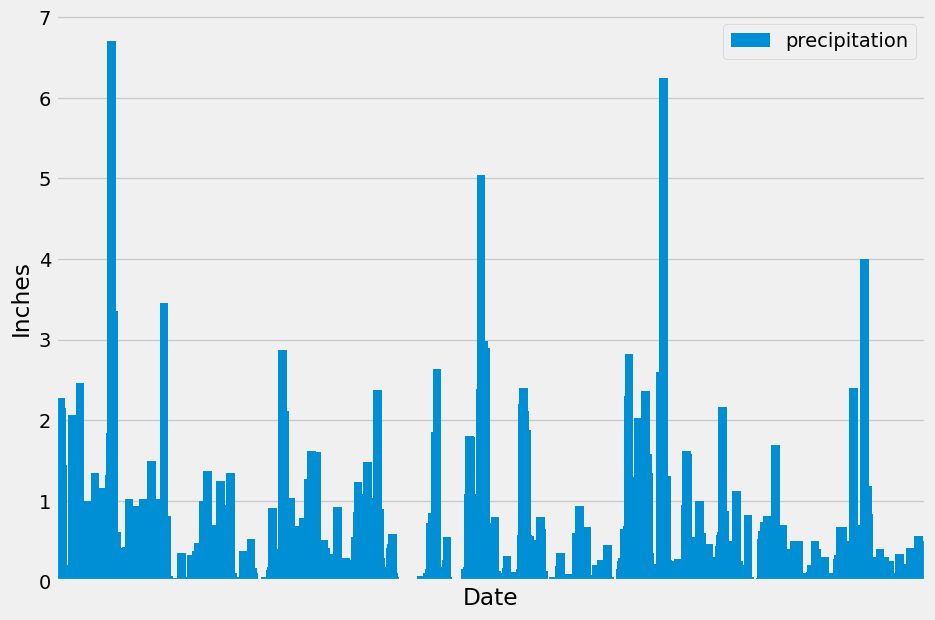

In [ ]:
#start date: 12 months prior to max date
start_date=max_date-dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores for last 12 months
sel=[Measurement.date,Measurement.prcp]

precipitation_data = session.query(*sel).\
                     filter(Measurement.date>=start_date).\
                     order_by(Measurement.date).all()

#Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(precipitation_data,columns=['date','precipitation'])

precipitation_df.dropna(inplace=True)

precipitation_df.set_index('date',inplace=True)

precipitation_df.head()
precip_plot=precipitation_df.plot.bar(figsize=(10,7),width=20,capstyle='round')

plt.xticks([])
plt.ylabel('Inches')
plt.xlabel('Date')

In [ ]:
precipitation_df.describe()


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
sel=[func.count(distinct(Station.name))]
cnt_stations=session.query(*sel).first()
cnt_stations

(9,)

In [ ]:
sel=[Measurement.station,func.count(Measurement.station)]

active_stations=session.query(*sel).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

temp_USC00519281=session.query(*sel).\
                filter(Measurement.station=='USC00519281').\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).first()

temp_USC00519281

(54.0, 85.0, 71.66378066378067)

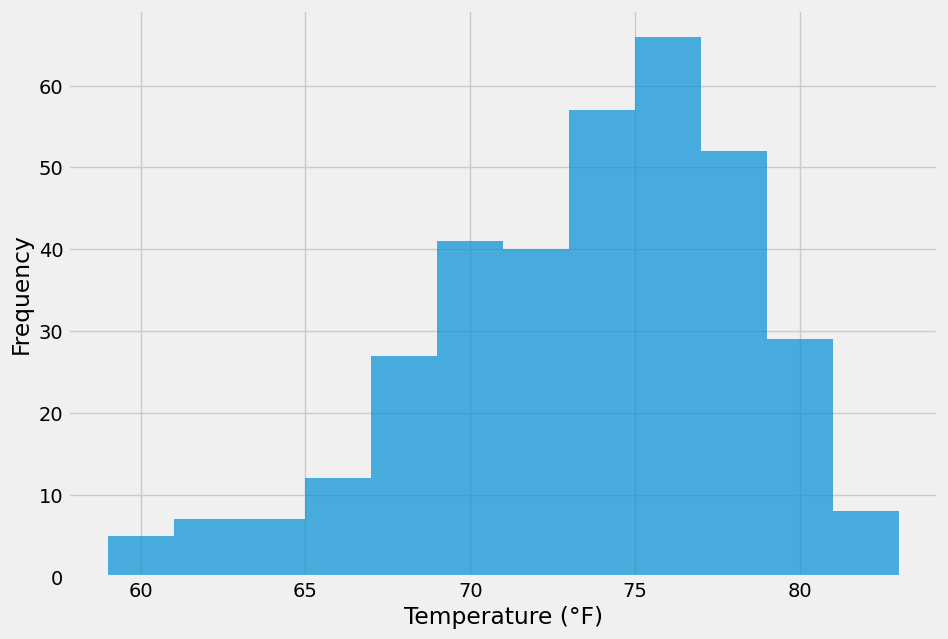

In [ ]:

sel=[Measurement.station]

temp_maxobs_station=session.query(*sel).\
                    filter(Measurement.tobs != None).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()[0]


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Measurement.date,Measurement.tobs).\
                          filter(Measurement.date>start_date).\
                          filter(Measurement.station==temp_maxobs_station).\
                          order_by(Measurement.date).all()

temp_data_df=pd.DataFrame(temp_data)

temp_data_df.plot.hist(y='tobs', bins=12, figsize=(10, 7), alpha=0.7, legend=False)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('')
plt.show()


# Close Session

In [ ]:
session.close()